In [107]:
%matplotlib inline
import numpy as np
import pandas as pd
import scipy.stats
from matplotlib import pyplot as plt
from IPython.display import HTML

In [2]:
plt.style.use('ggplot')

## Systems Cell Biology
### Motor simulations assignment 

**Samuel Morabito**

In [109]:
HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
Toggle code <a href="javascript:code_toggle()">here</a>.''')

### A:

Simulate a single kinesin-type motor stepping along a microtubule (MT). At
t=0 (the start of a ‘run’) it should attach to a microtubule. At each subsequent
timestep it should have a probability of stepping, or falling off the MT (which ends
the run). Each successful step should advance it 8 nm. You should adjust the
stepping frequency so that the average velocity is 800 nm/sec, and should adjust
the off rate (probability of falling off the MT for a given step) so that the mean
travel distance is 800 nm. Important: the ‘timestep’ of the simulation should be
relatively small compared to the frequency of stepping, so on many ‘iterations’ of
the simulation there will be no step; the probability of a step must be the same on
each iteration.

In [3]:
def simulate_microtubule(n, ts, off_thresh, step_thresh):
    
    # initialize simulation
    step = np.random.randint(1,ts)
    output = []
    
    # simulate n runs
    for i in range(n):
        
        n_ts = 0 #number of timesteps
        motor_steps = 0
        detach = off_thresh + 1
        
        while detach >= off_thresh:
            
            n_ts += 1
            step = np.random.randint(1,ts)
            
            if step < step_thresh: 
                detach = np.random.randint(1,ts)
                if detach < off_thresh:
                    output.append([motor_steps, 8*motor_steps, n_ts, motor_steps*8/(n_ts/ts), n])
                else:
                    motor_steps += 1
    
    return output      

In [5]:
df = pd.DataFrame(data=simulate_microtubule(10000, 10000, 99, 102),
                  columns=["motor_steps","travel_distance","time_steps","velocity", 'runs']) 

In [241]:
# display statistics
df.describe()

,motor_steps,travel_distance,time_steps,velocity,runs
count,15110.000000,15110.000000,15110.000000,15110.000000,15110.000000
mean,100.622237,804.977895,10061.803044,798.290861,7196.432826
std,101.777890,814.223119,10136.944969,208.093369,3957.611198
min,0.000000,0.000000,1.000000,0.000000,10.000000
25%,28.000000,224.000000,2853.000000,733.307956,2560.000000
50%,70.000000,560.000000,6977.000000,796.634154,10000.000000
75%,138.000000,1104.000000,13809.750000,861.546886,10000.000000
max,1053.000000,8424.000000,111867.000000,8000.000000,10000.000000


### B:

Simulate different numbers of trials(e.g. 10, 20, 40, 80, 160, 1000 individual
‘runs’) and make corresponding histograms showing the distribution of run
lengths.

Text(0.06,0.5,'number of runs')

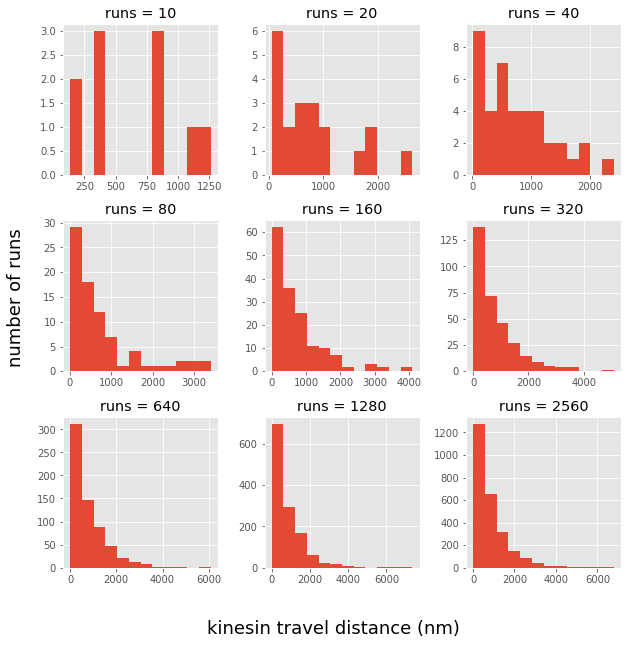

In [251]:
fig, axarr = plt.subplots(3,3, figsize=(10,10))
font = {'weight': 'normal',
        'size': 18}

runs = 10
for i in range(3):
    for j in range(3):
        cur_df = pd.DataFrame(data=simulate_microtubule(runs, 10000, 99, 102),
                      columns=["motor_steps","travel_distance","time_steps","velocity", "runs"]) 
        df = pd.concat([df, cur_df])
        cur_df.hist(column="travel_distance", ax=axarr[i,j], bins=12)
        axarr[i,j].set_title("runs = {}".format(runs))
        runs *= 2


fig.text(0.5, 0.04, 'kinesin travel distance (nm)', ha='center', va='center', fontdict=font)
fig.text(0.06, 0.5, 'number of runs', ha='center', va='center', rotation='vertical', fontdict=font)



In [253]:
df.describe()

,motor_steps,travel_distance,time_steps,velocity,runs
count,40660.000000,40660.000000,40660.000000,40660.000000,40660.000000
mean,100.868224,806.945794,10095.639621,798.296161,3748.858829
std,101.422947,811.383572,10107.545885,206.695202,3656.499826
min,0.000000,0.000000,1.000000,0.000000,10.000000
25%,28.000000,224.000000,2883.000000,731.629714,1280.000000
50%,70.000000,560.000000,7010.500000,796.204616,2560.000000
75%,140.000000,1120.000000,13950.500000,861.605283,2560.000000
max,1053.000000,8424.000000,111867.000000,8888.888889,10000.000000


### C:

Determine what sample size is required for reasonable estimate of the distribution’s
properties. First, confirm that your simulation is working correctly—generate a really large
number of runs (eg 10,000, and confirm that the mean travel is about 800 nm. If not, there is
a problem in your simulation). Next, for each choice of sample size from B, generate many
samples of that size, and determine a 95% CI (using standard t-test approach discussed in
class) and for each sample determine whether the calculated CI contains the actual mean of
the population (which you know to be 800 nm, by construction). Then, for that sample size,
determine the proportion of correct events, i.e. the number of tests that included 800, divided
by the total number of tests. Plot a graph of the proportion, as a function of the number of
elements in the sample. At some point (i.e. for some sample size N), the proportion should
get close to 0.95. When is that?
Finally, for each sample size, use the statistic we discussed in class (on proportions) : for
each sample size, does the 95% CI include 0.95?

In [6]:
def confidence_interval(df, num_runs, num_subsets, confidence=0.95):
    subsets = df.sample(num_runs)
    m, se = subsets.mean()["travel_distance"], scipy.stats.sem(subsets["travel_distance"])
    h = se * scipy.stats.t.ppf((1 + confidence) / 2., num_runs-1)
    return m, m-h, m+h

Text(0.5,1,'Confidence intervals')

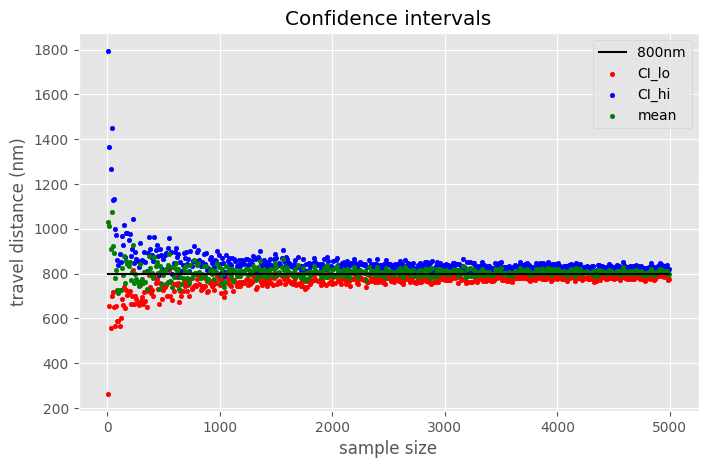

In [7]:
lower, means, upper = [],[],[]

for i in np.arange(10,5000,10):
    m,l,u = confidence_interval(df,i,6)
    lower.append(l)
    means.append(m)
    upper.append(u)

fig, ax = plt.subplots(1,1,figsize=(8,5),dpi=100)
ax.scatter(np.arange(10,5000,10), lower,s=10,color="red",label="CI_lo")
ax.scatter(np.arange(10,5000,10), upper,s=10,color="blue",label="CI_hi")
ax.scatter(np.arange(10,5000,10), means,s=10,color="green",label="mean")
ax.plot(np.arange(10,5000,10), [800 for i in range(len(means))],color="black",label="800nm")
ax.legend()
ax.set_xlabel("sample size")
ax.set_ylabel("travel distance (nm)")
ax.set_title("Confidence intervals")

In [12]:
trials = 100
sample_sizes = [10*(2**i) for i in range(8)]
correct = {sample: 0 for sample in sample_sizes}

for sample in sample_sizes:
    print(sample)
    for t in range(trials):
        cur_df = pd.DataFrame(data=simulate_microtubule(sample, 10000, 99, 102),
                              columns=["motor_steps","travel_distance","time_steps","velocity", "runs"])
        if 800 in cur_df["velocity"]:
            correct[sample] += 1

10
20
40
80
160
320
640
1280


In [13]:
correct

{10: 0, 20: 0, 40: 0, 80: 0, 160: 0, 320: 0, 640: 0, 1280: 100}

---
## 2 (velocity variation)

### A:

How does velocity variation change with the size of the window used to
calculate velocity? Show distributions

In [43]:
velo_df = pd.DataFrame(data=simulate_microtubule(100, 20000, 98, 102),
                  columns=["motor_steps","travel_distance","time_steps","velocity", 'runs']) 

In [44]:
velo_df.describe()

,motor_steps,travel_distance,time_steps,velocity,runs
count,100.000000,100.00000,100.000000,100.000000,100.0
mean,201.620000,1612.96000,40383.210000,797.079306,100.0
std,207.724798,1661.79838,41383.873752,114.415199,0.0
min,5.000000,40.00000,1515.000000,464.609800,100.0
25%,53.500000,428.00000,11249.750000,741.601014,100.0
50%,136.500000,1092.00000,25695.500000,790.153795,100.0
75%,301.250000,2410.00000,57664.750000,836.625694,100.0
max,1115.000000,8920.00000,217315.000000,1236.051502,100.0


In [29]:
def simulate_microtubule_window(n, ts, off_thresh, step_thresh, w):
    
    # initialize simulation
    step = np.random.randint(1,ts)
    output = []
    # simulate n runs
    for i in range(n):
        
        n_ts = 0 #number of timesteps
        motor_steps = 0
        previous_steps = 0
        detach = off_thresh + 1
        
        while detach >= off_thresh:
            
            n_ts += 1
            step = np.random.randint(1,ts)
       
            if step <= step_thresh: 
                detach = np.random.randint(1,ts)
                if detach <= off_thresh:
                    
                    break
                else:
                    motor_steps += 1
                
            if n_ts == ts*w:
                velo = (motor_steps - previous_steps)*8/w
                output.append(velo)
                n_ts = 0
                previous_steps = motor_steps
    
    return output     

Text(0.5,0.04,'kinesin travel distance (nm)')

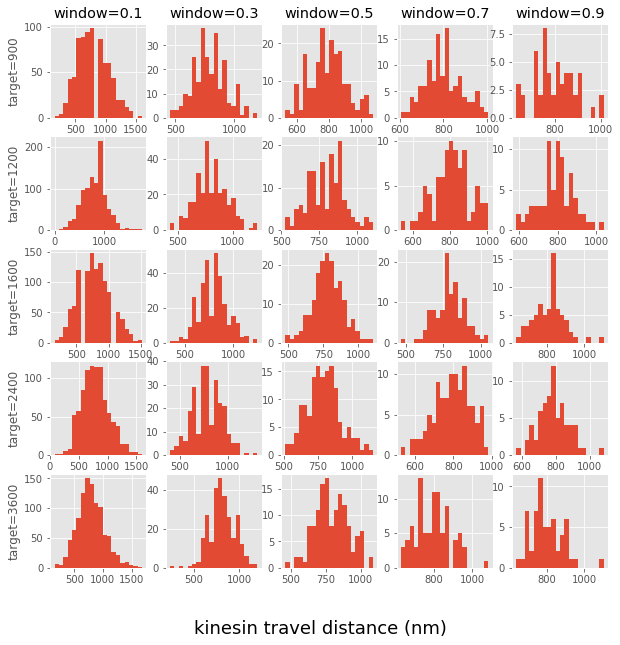

In [53]:
fig, axarr = plt.subplots(5,5, figsize=(10,10))
font = {'weight': 'normal',
        'size': 18}
targets = [900, 1200, 1600, 2400, 3600]
windows = [0.1, 0.3, 0.5, 0.7, 0.9]
probs = []
for i, target in enumerate(targets):
    sub_probs= []
    for j,w in enumerate(windows):
        v = simulate_microtubule_window(100, 10000, 100, 100, w)
        sub_probs.append(len([ve for ve in v if ve >= 900])/len(v))
        axarr[i][j].hist(v, bins=20)
        #plt.hist(v)
    probs.append(sub_probs)

for ax, target in zip(axarr[:,0], targets):
    ax.set_ylabel("target={}".format(target))
for ax, w in zip(axarr[0], windows):
    ax.set_title("window={}".format(w))

fig.text(0.5, 0.04, 'kinesin travel distance (nm)', ha='center', va='center', fontdict=font)

        

Text(0.5,0,'window size')

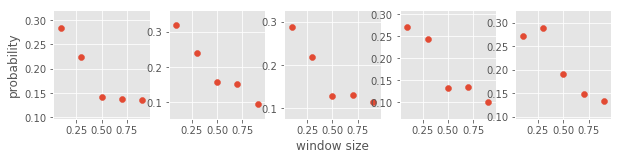

In [71]:
fig, axarr = plt.subplots(1,5, figsize=(10,2))
for i in range(5):
    axarr[i].scatter(windows, probs[i])
axarr[0].set_ylabel("probability")
axarr[2].set_xlabel("window size")

### 3:

In [104]:
def two_motor_simulation(n, ts, off_thresh, step_thresh, attach_thresh):

    #initialize simulation:
    step = np.random.randint(1,ts)
    output = []

    for i in range(n):

        d1, d2, m1, m2 = 0,0,True,True
        while m1 == True or m2 == True:
            #both motors attached:
            if m1 == True and m2 == True:
                # decide if motors will detach
                m1_detach = np.random.randint(0,ts)
                m1_step = np.random.uniform(0,ts)
                m2_detach = np.random.randint(0,ts)
                m2_step = np.random.uniform(0,ts)

                if m1_step <= step_thresh:
                    if m1_detach <= off_thresh: m1 = False
                    else: d1 += 1
                if m2_step <= step_thresh:
                    if m2_detach <= off_thresh: m2 = False
                    else: d2 += 1

                #did both fall off?
                if m1 == False and m2 == False:
                    output.append(max(d1,d2))

            #motor 1 attached only:
            elif m1 == True:
                m1_detach = np.random.randint(0,ts)
                m1_step = np.random.uniform(0,ts)
                m2_attach = np.random.randint(0,ts)
                # will motor 1 step?
                if m1_step <= step_thresh:
                    # will motor 1 detach?
                    if m1_detach <= off_thresh:
                        m1 = False
                        output.append(d1)
                    else:
                        d1 += 1
                if m2_attach <= attach_thresh: m2 = True
                        
            #motor 2 attached only:
            elif m2 == True:
                m2_detach = np.random.randint(0,ts)
                m2_step = np.random.uniform(0,ts)
                m1_attach = np.random.randint(0,ts)

                # will motor 1 step?
                if m2_step <= step_thresh:
                    # will motor 1 detach?
                    if m2_detach <= off_thresh:
                        m2 = False
                        output.append(d2)
                    else:
                        d2 += 1
                if m1_attach <= attach_thresh: m1 = True
    return output
                

Text(0,0.5,'num runs')

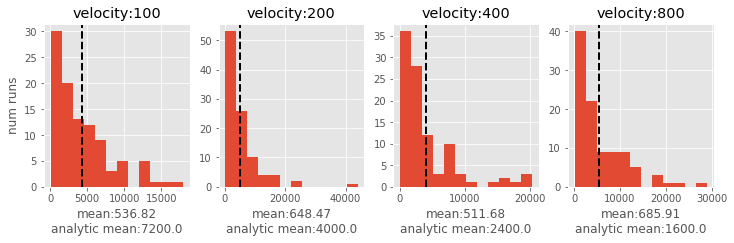

In [105]:
fig, axarr =plt.subplots(1, 4, figsize = (12,3))
for velo, step, ax in zip([100,200,400,800], [99.875, 99.75, 99.5, 99.], axarr):
    o = two_motor_simulation(100, 10000, 100, step, 10)
    
    pi = 2 # fixed on-rate, 2 per second
    analytic = 800*(1+(pi*800/(2*velo))) # calculate analytic solution from Lecture 3 slide #36, Analytic Mean-field theory 
    ax.hist(np.array(o)*8, bins=12)
    ax.axvline(x=np.mean(np.array(o)*8),color ='black',linewidth=2, linestyle='dashed')
#     plt.text(scipy.mean(np.array(distance)*8) + 500., hist[0].max()*0.75, 'Mean= %1.1f' % scipy.mean(np.array(distance)*8), fontsize=15)
#     plt.text(scipy.mean(np.array(distance)*8) + 500., hist[0].max()*0.60, 'Analytic mean= %1.1f' % analytic, fontsize=15)
    ax.set_title('velocity:{}'.format(velo))
    ax.set_xlabel('mean:{}'.format(np.mean(o)) + "\n" + 'analytic mean:{}'.format(analytic))
axarr[0].set_ylabel('num runs')



